# Image Vectorization and Cluster Balancing

The goal of this project is to improve the quality of data, used for the image classification model, by identifying and oversampling minority classes.

Method:
- Vectorize images
- Kmean clustering the vectors
- Rebalance the clusters

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf

In [ ]:
from skimage.filters import threshold_otsu
from skimage import color, measure
from skimage.feature  import corner_harris, corner_peaks, canny
from scipy import stats

import seaborn as sns
sns.set(rc={'figure.figsize':(9,5)})
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings("ignore")

# Import data

In [76]:
%%time
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

lean = x_train[:5000,:,:,:]
lean.shape

CPU times: total: 344 ms
Wall time: 405 ms


(5000, 32, 32, 3)

# Define Functions

In [77]:
def print_pic(data , location):
    plt.figure()
    plt.imshow(data[location])
    plt.title('No. '+ str(location))
    plt.show();

In [ ]:
def color_hist(image, peaks = 10):
    df = pd.DataFrame(image.ravel())
    return np.mean(image.ravel()) , np.std(image.ravel()), np.mean(df.value_counts()[:peaks])

def shape_size(image):
    block_size = 35
    local_thresh = threshold_otsu(image, block_size)
    binary_local = image > local_thresh
    return np.sum(binary_local)

def contur_count(image, min_shape = 2):
    thresh = threshold_otsu(image)
    thresholded_image = 1.0*(image > thresh)
    contours = measure.find_contours(thresholded_image ,0.8)
    contour_count = [cnt for cnt in contours if np.shape(cnt)[0] > min_shape]
    return len(contour_count)

def edge_len(image, sigma = 0.1):
    canny_edges = canny(image, sigma = sigma)
    return np.sum(canny_edges)

def corners(image):
    measure_image = corner_harris(image )
    coords = corner_peaks(corner_harris(image ), min_distance = 3, threshold_rel=0.02)
    return len(coords)


(32, 32, 3)


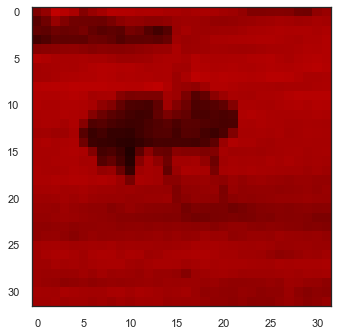

In [78]:
image = lean[42,:,:,:]
red = image.copy() 
red[:,:, [1,2]] = 0
print(red.shape)

plt.figure()
plt.imshow(red)
plt.show();

In [ ]:
def img_fingerprint(image):
    values = []
    
    red = image.copy()
    green = image.copy()
    blue = image.copy()

    red[:,:,[1,2]] = 0
    green[:,:,[0,2]] = 0
    blue[:,:,[0,1]] = 0

    redg = color.rgb2gray(red )
    greeng = color.rgb2gray(green )
    blueg = color.rgb2gray(blue )

    values.append(color_hist(redg)[0])
    values.append(color_hist(greeng)[0])
    values.append(color_hist(blueg)[0])

    values.extend([color_hist(redg)[1], color_hist(greeng)[1], color_hist(blueg)[1]])
    values.extend([color_hist(redg)[2], color_hist(greeng)[2], color_hist(blueg)[2]])
    values.extend([shape_size(redg), shape_size(greeng), shape_size(blueg)])
    values.extend([edge_len(redg), edge_len(greeng), edge_len(blueg)])
    values.extend([contur_count(redg), contur_count(greeng), contur_count(blueg)])
    values.extend([corners(redg), corners(greeng), corners(blueg)])

    return values

#img_fingerprint(lean[0,:,:,:])

In [79]:
def image_dataframe(im_list):
    #df = pd.DataFrame ()
    df = pd.DataFrame(columns = ['brightness_r', 'brightness_g', 'brightness_b',
                                'bscatter_r','bscatter_g', 'bscatter_b',
                                'intensity_r','intensity_g','intensity_b',
                                'area_r','area_g','area_b',
                                'perimeter_r','perimeter_g','perimeter_b',
                                'objects_r','objects_g','objects_b',
                                'corners_r','corners_g','corners_b'
                                ])
            

    for image in im_list:
        df.loc[len(df)] = img_fingerprint(image)

    return df

# Create Image vector

In [80]:
%%time
image_df = image_dataframe(lean)
image_df.head(5)

CPU times: total: 1min 46s
Wall time: 1min 46s


,brightness_r,brightness_g,brightness_b,bscatter_r,bscatter_g,bscatter_b,intensity_r,intensity_g,intensity_b,area_r,...,area_b,perimeter_r,perimeter_g,perimeter_b,objects_r,objects_g,objects_b,corners_r,corners_g,corners_b
0,0.117671,0.294856,0.018106,0.033886,0.119035,0.011549,20.9,21.1,21.9,252.0,...,176.0,185.0,283.0,16.0,16.0,13.0,8.0,6.0,6.0,4.0
1,0.108499,0.365738,0.036892,0.051660,0.168950,0.016736,10.6,10.4,11.1,480.0,...,516.0,265.0,323.0,0.0,14.0,12.0,16.0,6.0,6.0,6.0
2,0.111237,0.379169,0.037488,0.069652,0.231488,0.023061,33.3,33.1,33.5,362.0,...,341.0,144.0,186.0,71.0,6.0,6.0,4.0,4.0,3.0,3.0
3,0.083316,0.233639,0.016234,0.031662,0.089091,0.007033,21.3,25.5,28.8,139.0,...,111.0,95.0,317.0,0.0,6.0,5.0,8.0,3.0,4.0,5.0
4,0.076685,0.287283,0.032799,0.049287,0.157644,0.018003,14.6,17.4,12.6,298.0,...,367.0,183.0,229.0,62.0,4.0,7.0,7.0,3.0,3.0,3.0


## EDA and Transformations

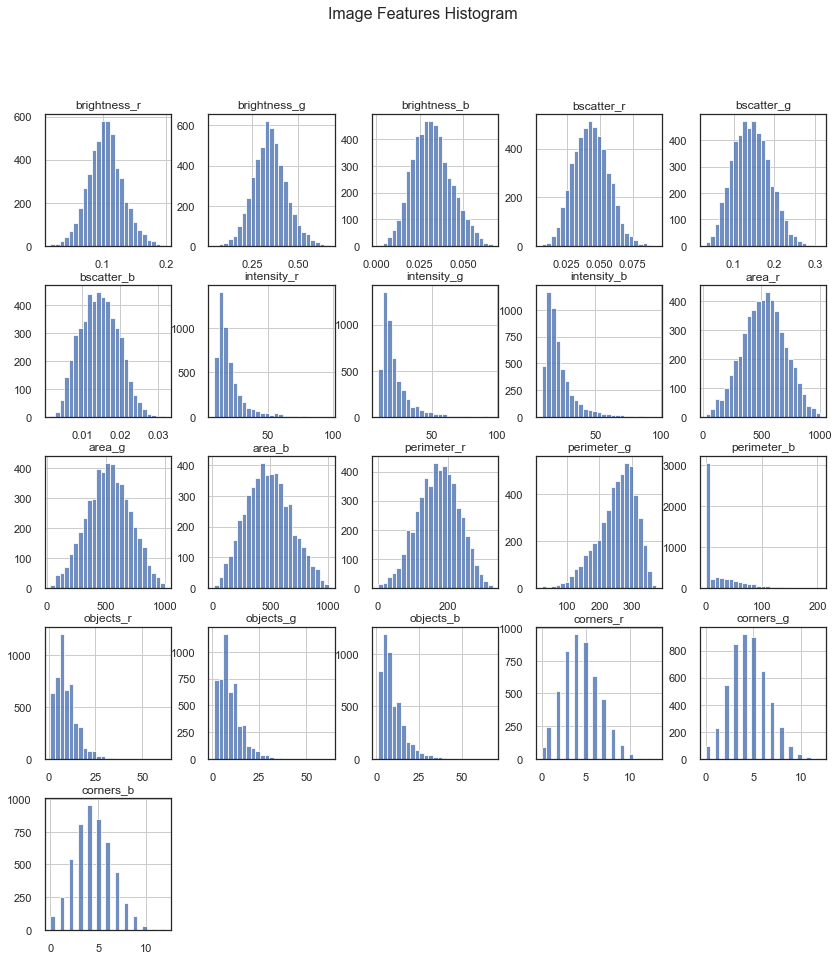

In [81]:
image_df.hist( figsize=(14,15),bins = 25, alpha = 0.8)
plt.suptitle("Image Features Histogram",size = 16);

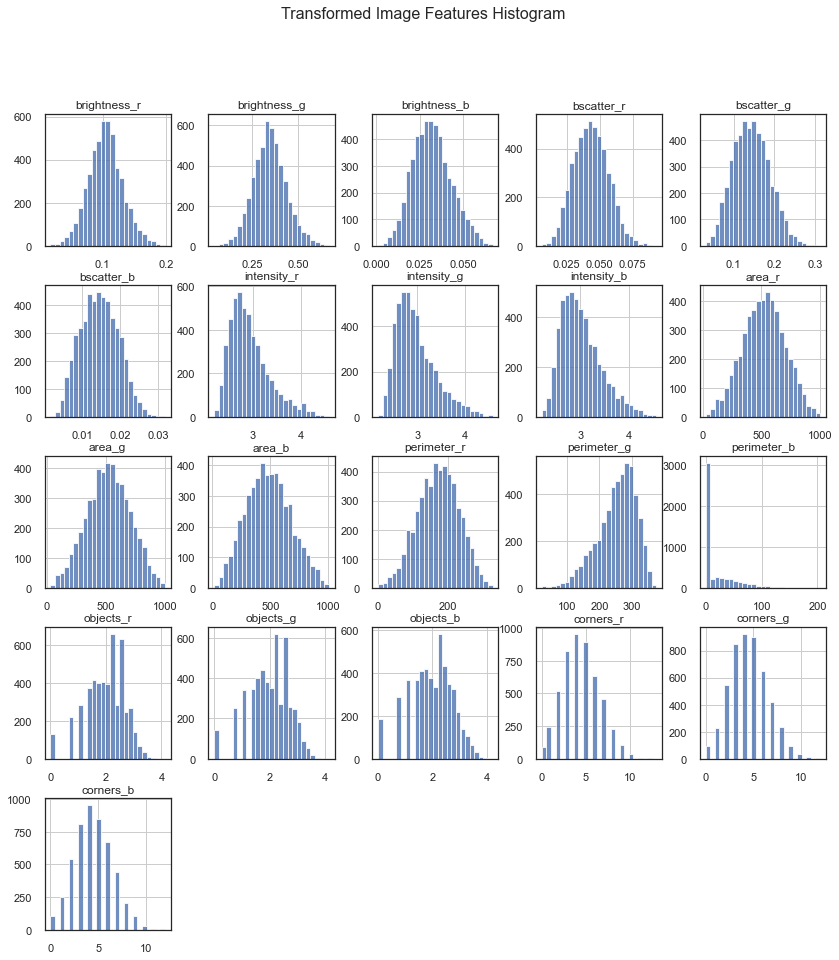

In [83]:
# log transform
image_df2 = image_df.copy()
columnstolog = ['intensity_r','intensity_g','intensity_b','objects_r','objects_g', 'objects_b']
image_df2[columnstolog] = np.log(image_df2[columnstolog])

image_df2.hist( figsize=(14,15),bins = 25, alpha = 0.8)
plt.suptitle("Transformed Image Features Histogram",size = 16);

## Check imbalance in train test

In [84]:
from sklearn.model_selection import train_test_split

image_df2 = image_df2.reset_index().rename(columns = {'index':'id'})
numerical_f = image_df2.columns.drop('id')

X_train, X_test = train_test_split( image_df2[numerical_f] , test_size=0.20, random_state=42)
distances = list(map(lambda i : stats.ks_2samp(X_train.iloc[:,i],X_test.iloc[:,i]).statistic,range(X_train.shape[1])))
print('Max diff:', round(np.max(distances),3),'\n')

for i in range(X_train.shape[1]):
    print(X_train.columns[i],"........",round(distances[i],3))

Max diff: 0.044 

brightness_r ........ 0.019
brightness_g ........ 0.017
brightness_b ........ 0.027
bscatter_r ........ 0.043
bscatter_g ........ 0.031
bscatter_b ........ 0.018
intensity_r ........ 0.027
intensity_g ........ 0.029
intensity_b ........ 0.023
area_r ........ 0.035
area_g ........ 0.022
area_b ........ 0.036
perimeter_r ........ 0.031
perimeter_g ........ 0.032
perimeter_b ........ 0.03
objects_r ........ 0.038
objects_g ........ 0.03
objects_b ........ 0.03
corners_r ........ 0.022
corners_g ........ 0.017
corners_b ........ 0.014


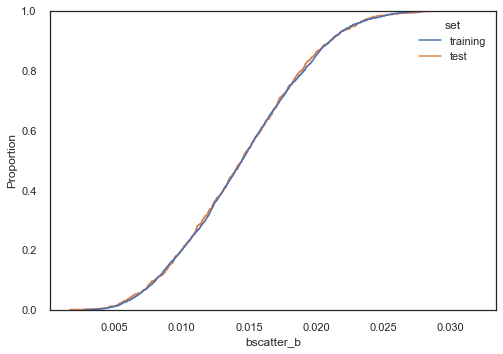

In [85]:
feature_name = 'bscatter_b'

df = pd.DataFrame({
    feature_name:np.concatenate((X_train.loc[:,feature_name],X_test.loc[:,feature_name])),
    'set':['training']*X_train.shape[0] + ['test']*X_test.shape[0]
    })
sns.ecdfplot(data=df,x=feature_name,hue='set');

## Train test disparity

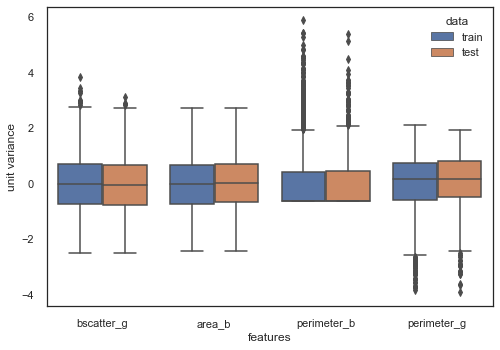

In [86]:
from sklearn.preprocessing import StandardScaler

def scaler_trans( train, valid, col):
    scaler = StandardScaler()
    
    train_t = pd.DataFrame(scaler.fit_transform(train[col]), columns = col, index = train.index)
    valid_t = pd.DataFrame(scaler.transform(valid[col]), columns = col, index = valid.index)
    
    train_t = pd.concat([train_t, train.drop(col, axis=1)], axis=1)
    valid_t = pd.concat([valid_t, valid.drop(col, axis=1)], axis=1)
    
    return train_t, valid_t 

X_train_s, X_test_s = scaler_trans( X_train, X_test, numerical_f)

columns_interest = ['bscatter_g', 'area_b', 'perimeter_b','perimeter_g']

data1 = X_train_s[columns_interest].assign(data='train')
data2 = X_test_s[columns_interest].assign(data='test')

cdf = pd.concat([data1, data2])    
mdf = pd.melt(cdf, id_vars=['data'], var_name=['features'])
mdf = mdf.rename(columns = {'value':'unit variance'})

ax = sns.boxplot(x="features", y="unit variance", hue="data", data=mdf)    
plt.show();

## Rebalance train-test

In [87]:
%%time
n_features = image_df.shape[1]
n_tries = 100
result = []

for random_state in range(n_tries):
    X_train, X_test = train_test_split( image_df2[numerical_f] , test_size=0.2, random_state=random_state)

    distances = list(map(lambda i : stats.ks_2samp(X_train.iloc[:,i],X_test.iloc[:,i]).statistic,range(n_features)))
    
    result.append((random_state,max(distances)))

result.sort(key = lambda x : x[1])
print(result[:3])
print('Best random seed for balanced trained-test features: ', result[:1][0][0],'\n')

[(48, 0.02875), (63, 0.03275), (60, 0.03375)]
Best random seed for balanced trained-test features:  48 

CPU times: total: 4.44 s
Wall time: 4.44 s


<AxesSubplot:xlabel='bscatter_b', ylabel='Proportion'>

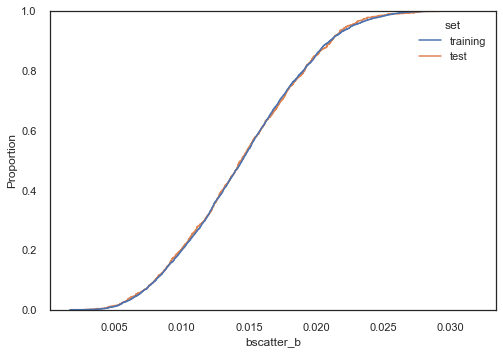

In [88]:
feature_name = 'bscatter_b'
X_train, X_test = train_test_split( image_df2[numerical_f] , test_size=0.2, random_state= result[:1][0][0])

df = pd.DataFrame({
    feature_name:np.concatenate((X_train.loc[:,feature_name],X_test.loc[:,feature_name])),
    'set':['training']*X_train.shape[0] + ['test']*X_test.shape[0]
    })
sns.ecdfplot(data=df,x=feature_name,hue='set')

# Group images into clusters using - kmeans

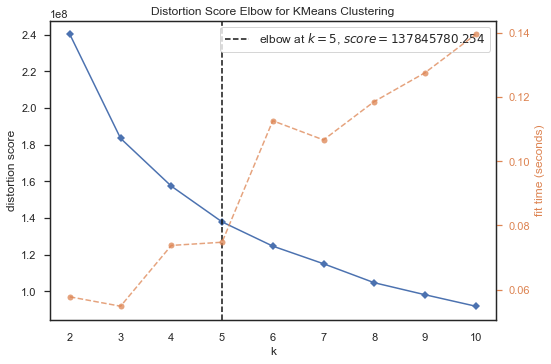

In [89]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
model = KElbowVisualizer(KMeans(), k=10)
model.fit(X_train[numerical_f])
model.show();

In [90]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_train[numerical_f])
X_train['cluster'] = kmeans.labels_
X_test['cluster'] = kmeans.predict(X_test[numerical_f])
round(100*X_train.cluster.value_counts()/len(X_train),2)

4    32.72
0    28.92
1    18.15
3    13.88
2     6.32
Name: cluster, dtype: float64

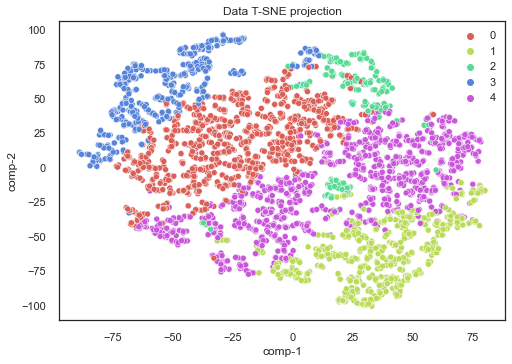

In [91]:
#TSNE
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=10).fit_transform(X_train[numerical_f])

df = pd.DataFrame()
df["y"] = X_train['cluster']
df["comp-1"] = X_embedded[:,0]
df["comp-2"] = X_embedded[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 5),
                data=df).set(title="Data T-SNE projection");

### Compare different clusters:

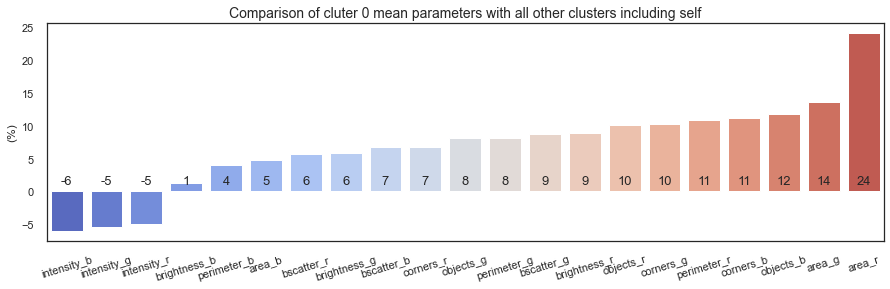

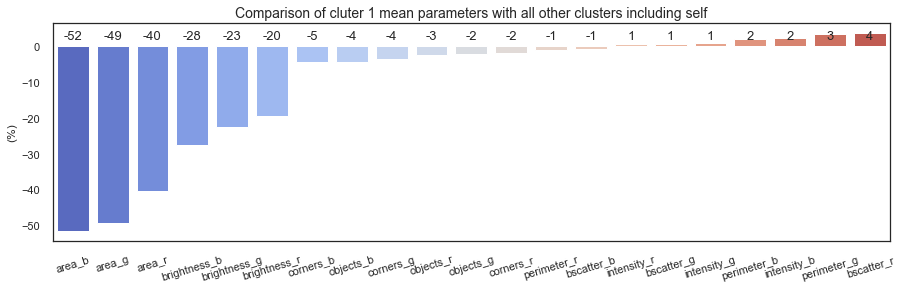

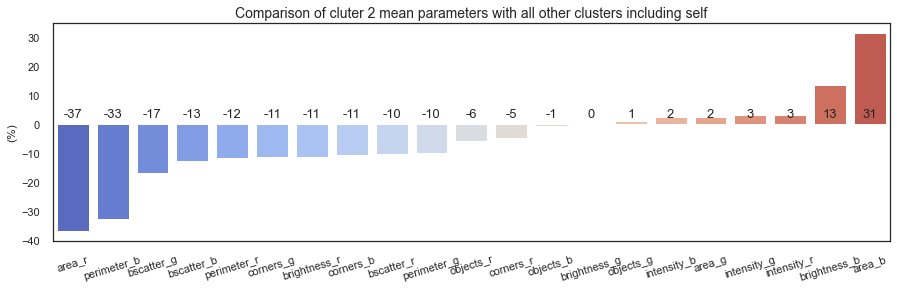

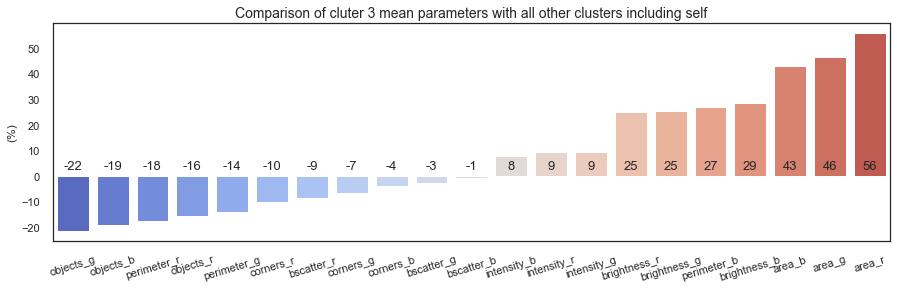

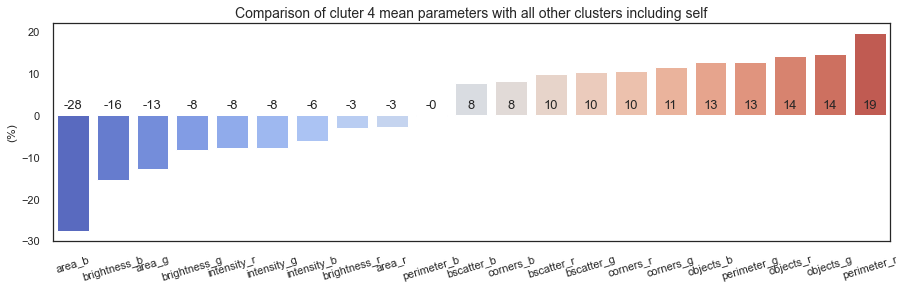

In [92]:
clusters = X_train.groupby('cluster').mean().reset_index()

for num in range(5):
    clust_num = num
    clust =  100*clusters[clusters.cluster == clust_num].drop(['cluster'], axis=1)/clusters.drop('cluster', axis=1).mean()-100
    clust = clust.T
    clust.columns = ['cluter '+ str(clust_num)]
    clust = clust.sort_values('cluter '+ str(clust_num)).T
    
    sns.set(style='white')
    plt.figure(figsize=(15, 4))
    ax = sns.barplot( data=clust, ci=None, palette=sns.color_palette("coolwarm", 22))
    ax.tick_params(axis='x', rotation=17)

    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.0f'),
                       (bar.get_x() + bar.get_width() / 2,
                       0), ha='center', va='center',
                       size=13, xytext=(0, 10),
                       textcoords='offset points')

    plt.title('Comparison of ' + clust.index[0] + ' mean parameters with all other clusters including self', size=14)
    plt.ylabel('(%)', size=12)
    plt.show();


# Rebalance train dataset clusters by under and over sampaling

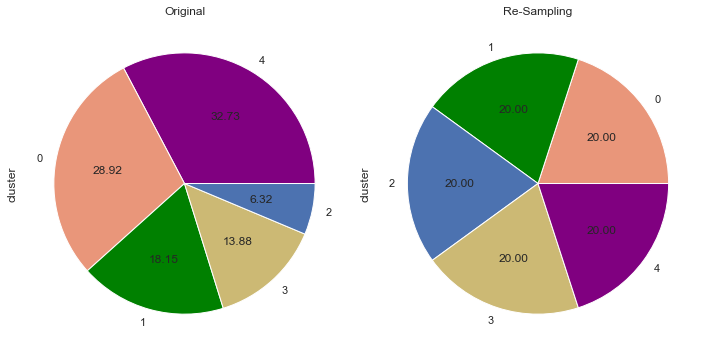

In [93]:
# define resampling
# knn undersampaling of the majority class
# random over sampaling of the minority classes
from imblearn.under_sampling import EditedNearestNeighbours 
from imblearn.over_sampling import RandomOverSampler

colors={0:'darksalmon', 
        1:'green',
        2:'b',
        3:'y',
        4:'purple'}

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
autopct = "%.2f"

X_train['cluster'].value_counts().plot.pie(autopct=autopct, ax=axs[0],
                                          colors=[colors[v] for v in X_train['cluster'].value_counts().keys()])
axs[0].set_title("Original")

enn=EditedNearestNeighbours(sampling_strategy='majority') # 'not minority'
#sampling_strategy = {1: 70, 4: 21,2:70} # 'minority'
ros = RandomOverSampler(random_state=42)

X_res, y_res = enn.fit_resample(X_train[numerical_f], X_train['cluster'])
X_res, y_res = ros.fit_resample(X_res, y_res,  )

y_res.value_counts().plot.pie(autopct=autopct, ax=axs[1],
                             colors=[colors[v] for v in y_res.value_counts().keys()])
axs[1].set_title("Re-Sampling")
fig.tight_layout();

# Conclusions:
- Images contain data that can be extracted as a way to differentiate them.
- Most features have a normal distribution, those that aren't can be log() transformed
- By finding a random seed that gives the lowest stats.ks_2samp(), we can decrease the maximum Kolmogorov-Smirnov between train-test features
- KElbowVisualizer is great tool for finding the optimal number of clusters for the dataset
- By placing each data point on a two-dimensional map, TSNE simplifies the comprehension of high-dimensional data
- As expected, each cluster has its own unique characteristics
- When re-sampling it is more efficient to undersample the majority class before oversampling